In [81]:


import _init_paths
from PIL import Image
import numpy as np
import cv2
import random
import copy

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import torch.nn.functional as F

from dall_e  import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown
from vcl.models.vqvae import *
from vcl.models.trackers import *
from vcl.utils import *
from mmcv.runner import get_dist_info, init_dist, load_checkpoint

import matplotlib.pyplot as plt
%matplotlib inline

target_image_size = 256

samples = []
with open('/home/lr/dataset/YouTube-VOS/2018/train/test_records.txt', 'r') as f:
    for line in f.readlines():
        name, frame_idx, pixel_idx = line.strip('\n').split()
        samples.append([name, int(frame_idx), int(pixel_idx)])
        
visualizer = Correspondence_Visualizer(mode='flow')
visualizer_hr = Correspondence_Visualizer(mode='flow', scale=64)

output_dir = '/home/lr/project/vcl_output/vis_flow'

if os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)



def main(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    # visualize_correspondence_quant(enc1, enc2, sample_idx, frame1, frame2, scale=32)
    return plt

def main_hr(x1, x2, model, frame1, frame2, gt):
    enc1 = model.backbone(x1.cuda())
    enc2 = model.backbone(x2.cuda())
    plt = visualizer_hr.visualize([enc1, enc2], [x1, x2], [frame1, frame2], gt)
    return plt

In [82]:
## sample frame
import os.path as osp
import glob


# sample_video_idx = 92
sample_video_idx = random.randint(0, 300)
sample = {}
sample['frames_path'] = sorted(glob.glob(osp.join('/home/lr/dataset/YouTube-VOS/2018/train/JPEGImages', samples[sample_video_idx][0], '*.jpg')))


frame_idx = samples[sample_video_idx][1]
sample_idx = samples[sample_video_idx][2]
video_name = sample['frames_path'][0].split('/')[-2]


frame1 = cv2.imread(sample['frames_path'][frame_idx])[:,:,::-1]
frame2 = cv2.imread(sample['frames_path'][frame_idx+1])[:,:,::-1]
gt = cv2.imread(sample['frames_path'][frame_idx].replace('JPEGImages', 'Flows_s256'))


frame1 = cv2.resize(frame1, (256,256))
frame2 = cv2.resize(frame2, (256,256))
gt = cv2.resize(gt, (256,256))[:,:,1:].astype(np.float32) / 255 - 0.5


print('sample frames from {}'.format(sample['frames_path'][0]))

x1_rgb = preprocess_(frame1, mode='rgb')
x2_rgb = preprocess_(frame2, mode='rgb')

x1_lab = preprocess_(frame1, mode='lab')
x2_lab = preprocess_(frame2, mode='lab')

sample frames from /home/lr/dataset/YouTube-VOS/2018/train/JPEGImages/f6e501892c/00045.jpg


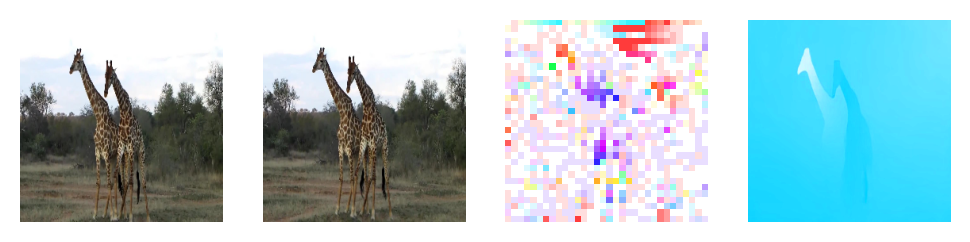

In [83]:

model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )

params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_12_2/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)


model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

model_name = 'mast'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

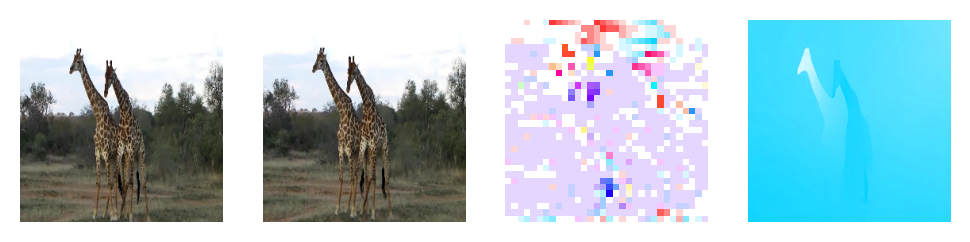

In [84]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_mast_14/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

model_name = 'mast_vq'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

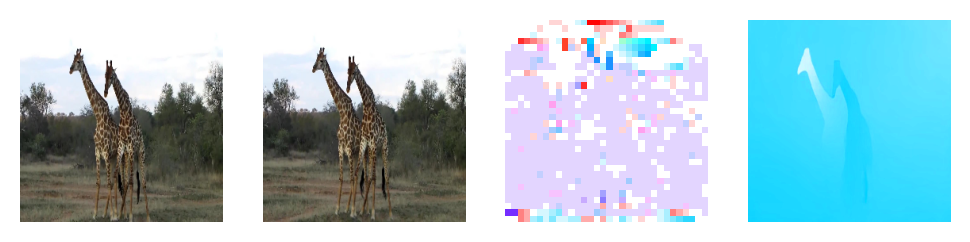

In [85]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/vqvae_mlm_d4_nemd2048_byol_dyt_nl_l2_fc_orivq_withbbox_random_v2_38/epoch_3200.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

model_name = 'vq'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

In [86]:
# model = VanillaTracker(
#     backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(2, )),
#     test_cfg=dict(),
#     train_cfg=dict()
#     )
# params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/train_vqvae_video_d4_nemd2048_contrastive_byol_commit1.0_v2/epoch_3200.pth')
# state_dict = params['state_dict']
# state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
# model.load_state_dict(state_dict, strict=False)

# model = model.cuda()
# model.eval()
# main(x1_rgb, x2_rgb, model, frame1, frame2, gt)

2022-03-30 00:08:41,339 - vcl - INFO - Loading /home/lr/models/vcl/ytvos_e060_res4_revise_keys.pth as torchvision
2022-03-30 00:08:41,428 - vcl - INFO - These parameters in pretrained checkpoint are not loaded: {'emb_q.bn1.weight', 'emb_q.bn1.running_mean', 'emb_q.conv1.bias', 'emb_q.bn1.running_var', 'emb_q.bn1.bias', 'emb_q.conv2.bias', 'emb_q.bn1.num_batches_tracked', 'emb_q.conv2.weight', 'emb_q.conv1.weight'}


Use load_from_local loader


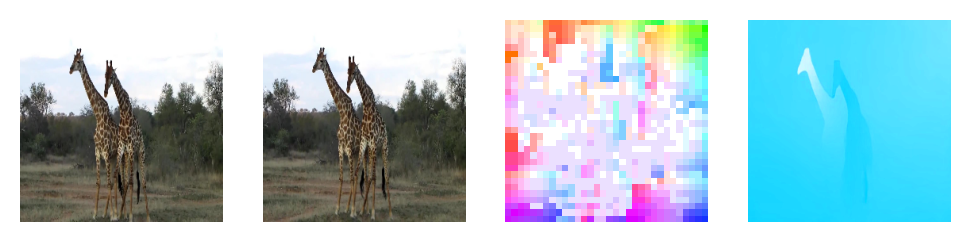

In [87]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, ), pretrained='/home/lr/models/vcl/ytvos_e060_res4_revise_keys.pth'),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/models/vcl/ytvos_e060_res4_revise_keys.pth')
# state_dict = params['model']
# state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
# print(state_dict.keys())
# model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
plt = main(x1_rgb, x2_rgb, model, frame1, frame2, gt)

model_name = 'duv'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

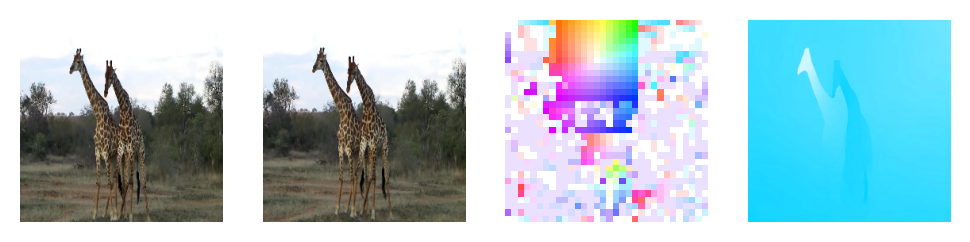

In [88]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 2, 1, 1), out_indices=(3, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/dist_nl_l2_layer4_mast_36/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
plt = main(x1_lab, x2_lab, model, frame1, frame2, gt)

model_name = 'mast_vfs_distillation'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))

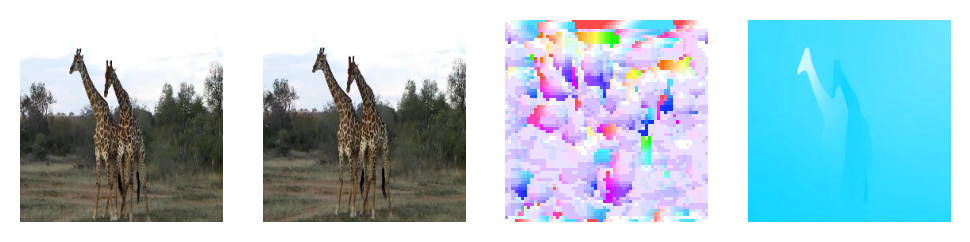

In [89]:
model = VanillaTracker(
    backbone=dict(type='ResNet', depth=18, strides=(1, 1, 1, 1), out_indices=(2, )),
    test_cfg=dict(),
    train_cfg=dict()
    )
params = torch.load('/home/lr/expdir/VCL/group_vqvae_tracker/dist_nl_l2_layer4_mast_d2/epoch_1600.pth')
state_dict = params['state_dict']
state_dict = { k:v for k,v in state_dict.items() if k.find('backbone') != -1}
model.load_state_dict(state_dict, strict=False)

model = model.cuda()
model.eval()
plt = main_hr(x1_lab, x2_lab, model, frame1, frame2, gt)

model_name = 'mast_d2'
os.makedirs(os.path.join(output_dir,model_name), exist_ok=True)
plt.savefig(os.path.join(output_dir,model_name,video_name+'.png'))